# Classification

簡單來說，訓練一個模型(分類器)，他的運作方式是依照決策函數給每個觀察值一個分數，我們再依照threshold決定將觀察值分給陽性類還是陰性類，重點在於分類器給的分數有沒有好好給

以下所有地方的some_digit都是Miniset資料集的第一列(只含X不包含Y)，他的Y是一個5

## Setup

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import randint
import joblib
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain

為了防止一些Sklearn更新的不必要警告:

In [3]:
# import warnings filter
from warnings import simplefilter
#ugnore all future warnings
simplefilter(action='ignore', category=FutureWarning)

創建 images/classification 文件夾（如果它尚不存在），並定義通過save_fig() 函數來保存圖形：

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Read in Data

Scikit-Learn 提供了許多輔助函數，以便於下載流行的數據集。 MNIST 是其中一個。

In [5]:
mnist = fetch_openml('mnist_784', as_frame=False)#as_frame=False是因為這個資料集是圖片，不能放倒dataframe

一般而言，由 sklearn 加載的數據集有著相似的字典結構，這包括：

* DESCR鍵描述數據集
  
* data鍵存放一個2D Numpy Array，一行表示一個觀察值，一欄表示一個特徵

* target鍵存放標籤(Y)，一個1D Numpy Array

In [6]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

看看資料敘述

In [7]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [8]:
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
X.shape

(70000, 784)

有 70,000 張圖片，每張圖片有 784 個特徵。 這是因為每個圖像是28×28像素，每個特徵簡單代表一個像素的強度，從0（白色）到 255（黑色）。

In [10]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [11]:
y.shape

(70000,)

讓我們看一下數據集中的一個數字。 所有你需要的要做的是獲取一個實例的特徵向量，將其reshape為 28×28 array，並使用Matplotlib 的 imshow() 函數：

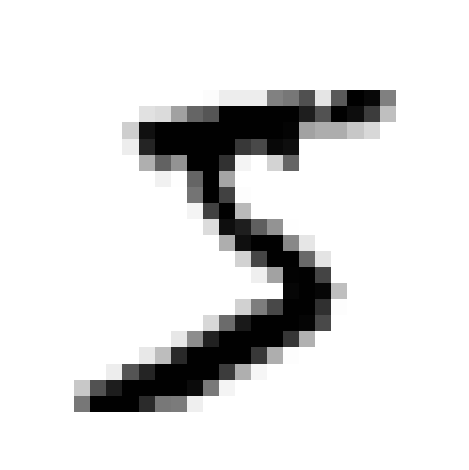

In [12]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
save_fig("some_digit_plot")#將圖片儲存到前面創建的資料夾
plt.show()

In [13]:
y[0]

'5'

是個5>

## Spliting Trainging and Testing Set

在仔細檢查數據之前，應該始終創建一個測試集並將其放在一邊。 MNIST 數據集實際上已經分為訓練集（前 60,000 張圖像）和測試集（最後 10,000 張圖像）：

In [14]:

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us，這很好，因為這保證了所有交叉驗證的fold都是相似的（不希望一個fold缺少一些數字）。 此外，一些算法對訓練observation的順序很敏感，如果連續獲得許多相似的observation，它們的性能就會很差。 打亂數據集可確保不會發生這種情況。

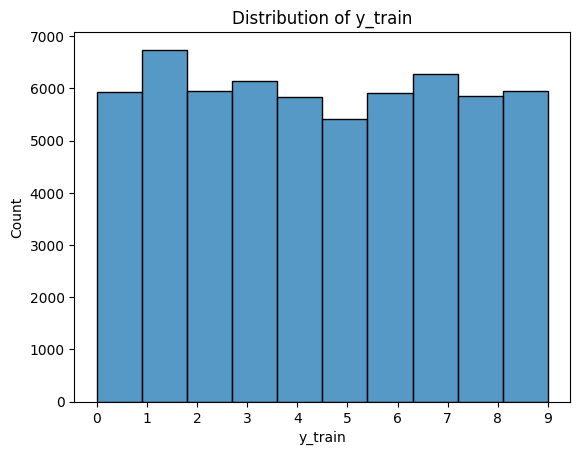

In [15]:
df_y_train = pd.DataFrame(y_train, columns=['y_train'])

# Convert the 'y_train' column to numeric values
df_y_train['y_train'] = pd.to_numeric(df_y_train['y_train'])

# Plot the distribution using a bar plot
sns.histplot(data=df_y_train, x='y_train', bins=10)
plt.title('Distribution of y_train')
plt.xlabel('y_train')
plt.ylabel('Count')

# Arrange x-labels from 0 to 9
plt.xticks(range(10))

plt.show()

## Training a Binary Classifier

現在讓我們簡化問題，只嘗試識別一個數字——例如，數字 5。這個“5-detector”將是二元分類器的一個例子，能夠區分圖像是不是5 。

In [16]:
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

一個好的起點是使用 Scikit-Learn 的 SGDClassifier 類的隨機梯度下降 (SGD) 分類器。 該分類器的優點是能夠有效處理非常大的數據集。 這部分是因為 SGD 獨立處理觀察值，一次一個（這也使 SGD 非常適合在線學習）

In [17]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

predict

In [18]:
sgd_clf.predict([some_digit])

array([ True])

使用交叉驗證

方法一 

In [19]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

方法二 Stratified Cross Validation

有時，您需要進行比 Scikit-Learn 提供的現成交叉驗證更多的控制。 在這種情況下，可以自己實施交叉驗證

StratifiedKFold執行分層抽樣以生成的各fold能夠包含每個類的代表性比率d。 在每次迭代中創建分類器的克隆，在訓練fold上訓練克隆，並在驗證fold上進行預測。

In [20]:
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)#當你需要策略性分配各類別比例給各fold驗證集時加上shuffle=True

for train_index, validation_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_validation_fold = X_train[validation_index]
    y_validation_fold = y_train_5[validation_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_validation_fold)
    n_correct = sum(y_pred == y_validation_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


找參數時使用 RandomizedSearchCV 搭配 StratifiedKFold(看留言) :  https://stackoverflow.com/questions/51944281/how-to-correctly-implement-stratifiedkfold-with-randomizedsearchcv

In [21]:
#clf_random = RandomizedSearchCV(estimator = clf(或是pipeline), param_distributions = random_grid, score = 'accuracy', n_iter = 100, cv = StratifiedKFold(n_splits=5),verbose=2, random_state=42, n_jobs = -1)
#clf_random.fit(X_train, y_train)
#print(clf_random.cv_results_)


Accuracy很高，但其實是因為只有大約 10% 的圖像是 5，所以如果總是猜測圖像不是 5，那麼大約 90% 的情況下都是正確的。

這說明了為什麼Accuracy通常不是分類器的首選性能指標，尤其是在處理skewed datasets時

## Confusion Matrix

就像 cross_val_score() 函數一樣，cross_val_predict() 執行 K 折交叉驗證，但它不返回評估分數，而是返回對每個驗證fold進行的預測。 這意味著對訓練集中的每個觀察值都得到了一個乾淨的預測（“乾淨”意味著預測是由一個在訓練期間從未見過數據的模型做出的），其實就是leave one out 的概念。

In [165]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

方法一

In [166]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

混淆矩陣中的每一列代表一個實際類別，而每一欄代表一個預測類別。

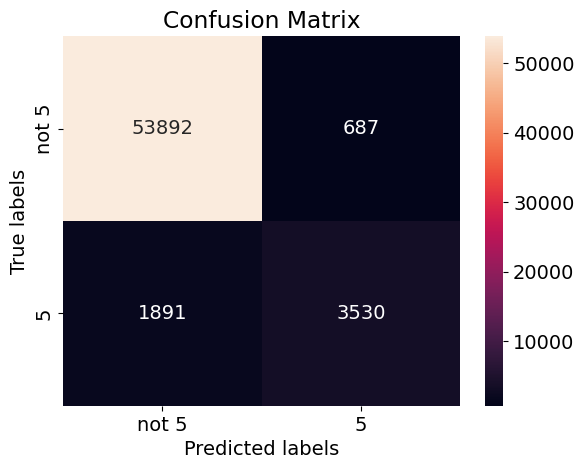

In [167]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['not 5', '5']); ax.yaxis.set_ticklabels(['not 5', '5']);

方法二

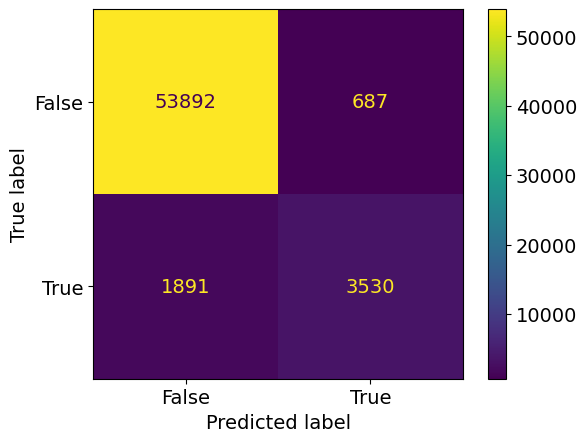

In [171]:
ConfusionMatrixDisplay.from_predictions(y_train_5, y_train_pred)
plt.show()

### Accuracy, Precision, Recall and F1 Score

* Accuracy

In [25]:
accuracy_score(y_train_5, y_train_pred)

0.9570333333333333

* precision

In [26]:
precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.8370879772350012

or

In [27]:
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

* recall

In [28]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

or

In [29]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

* F1 Score

In [30]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

or

In [31]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

### Threshold(閾值)

對於每個obsevation，分類器根據決策函數計算一個分數，如果該分數大於閾值，它分配給positive類，否則將其分配給negative類。所以簡單來說，閾值大代表你很嚴格，觀察值只要有一點不那麼像就不會被歸類到positive，因此會有較多False Negative(recall因此低);閾值小代表你很不嚴格，觀察值只要有一點像就歸類到positive，因此會有較多False Positive(precision因此低)。

Scikit-Learn 不允許直接設置閾值，但可以讓訪問用於進行預測的決策分數。 可以調用 decision_function() 方法，而不是調用分類器的 predict() 方法，該方法返回每個觀察值的分數，然後使用你想要的任何閾值根據這些分數進行預測：

In [32]:
some_digit

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

分類器給這個觀察值得分數

In [33]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

當閾值為0時

In [34]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

因為'some_digit'的分數大於閾值，因此此觀察值被判別為5

當閾值為3000時

In [35]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

'some_digit'此時被判別為不是5了

**這證實了提高閾值會降低recall。** 該圖像實際上表示一個 5，分類器在閾值為 0 時檢測到它，但是當閾值增加到 3000 時它就錯過了。

如何決定使用哪個閾值？ 首先需要再次使用 cross_val_predict() 函數獲取訓練集中所有實例的分數，但這次指定它返回決策分數而不是預測：

In [36]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

計算所有可能閾值的precission和recall（該函數添加最後一個precision 0 和最後一個recall 1，對應於閾值=無限），然後作圖

In [37]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

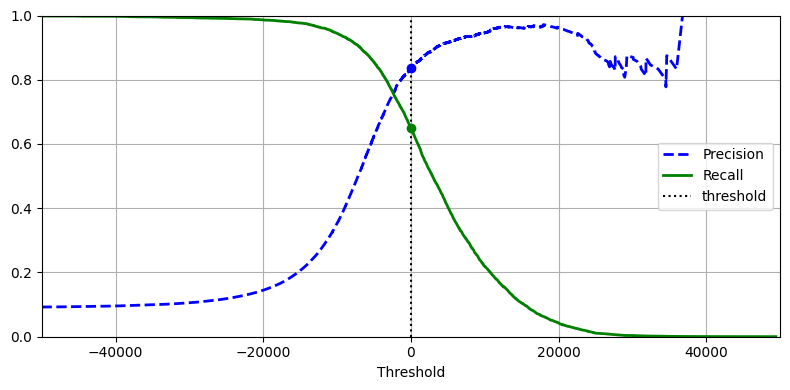

In [38]:
threshold = 0

plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

此時便能根據想要的precision或是recall來設置threshold了，根據你的project case by case看怎樣設合適

**為什麼precision曲線比recall曲線更顛簸?原因是當提高閾值時，精度有時會下降（儘管一般來說，它會向上）。另一方面，recall在閾值增加時永遠會下降，這也解釋了為什麼它的曲線看起來很平滑。**

假設決定以 90% 的precision為目標。 查看圖，發現需要使用大約 8,000 的閾值，但這樣不精確。搜索至少能提供 90% 精度的最低閾值（np.argmax() 將為我們提供最大值的索引，在本例中表示第一個True Value）：

In [39]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

然後，要進行預測（目前在訓練集上），可以運行以下代碼(而不是調用分類器的 predict() 方法)：

In [40]:
y_train_pred_90_precision = (y_scores >= threshold_for_90_precision)
y_train_pred_90_precision

array([False, False, False, ...,  True, False, False])

precision

In [41]:
precision_score(y_train_5, y_train_pred_90_precision)

0.9000345901072293

recall

In [42]:
recall_score(y_train_5, y_train_pred_90_precision)

0.4799852425751706

另一種選擇良好的precision/recall權衡的作圖方法

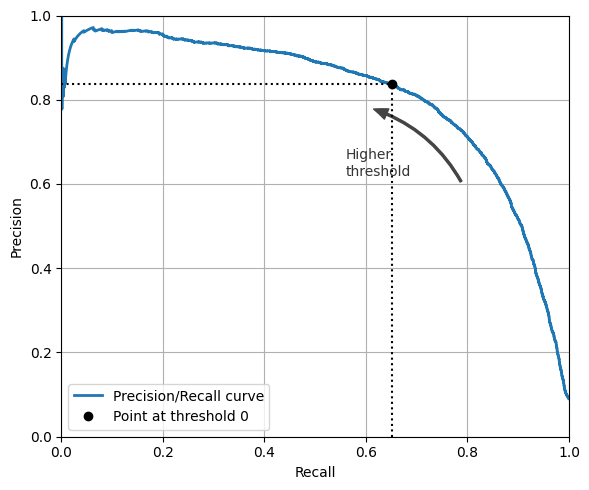

In [43]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 0")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

### ROC Curve

閾值(threshold)變化可以得到Sensitivity(也稱為True Positive Rate (TPR), Recall)指標和Specificity(也稱為True negative rate (TNR))指標，所以我們將所有可能的閾值(threshold)都去設定，然後可以跑出很多組Sensitivity和Specificity，一個靈敏性會對上一個特異性，因此把所有可能的連起來得到的就是ROC曲線了。

In [46]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

作ROC圖並切將上面90% Precision的點飆出來

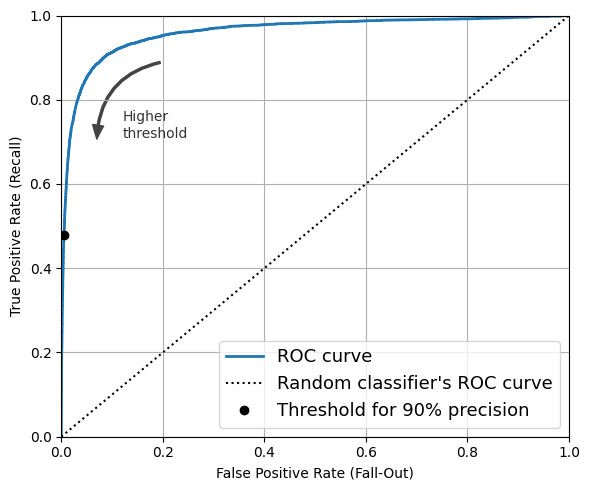

In [47]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

### AUC

比較分類器的一種方法是測量曲線下面積 (AUC)。 完美分類器的 ROC AUC 等於 1，而純隨機分類器的 ROC AUC 等於 0.5。

(目前都還在training set上)

In [50]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### 看ROC曲線還是precision/recall曲線?

由於 ROC 曲線與 precision/recall（或 PR）曲線非常相似，你可能想知道如何決定使用哪一個。 根據經驗，只要陽性類別很少見，或者當您更關心假陽性而不是假陰性時，您應該使用 PR 曲線，否則應該使用 ROC 曲線。 比如看之前的ROC曲線（還有ROC AUC score），可能會覺得這個分類器真的不錯。 但這主要是因為與negative（非 5 分）相比，positive（5 分）很少。 相比之下，PR 曲線清楚地表明分類器還有改進的空間（更好的分類器，PR曲線更能靠近右上角）。

### RandomForestClassifier

讓我們訓練一個 RandomForestClassifier 並將其 ROC 曲線和 ROC AUC 分數與 SGDClassifier 進行比較。首先，需要獲得訓練集中每個obsevation的分數。但是由於RandomForestClassifier 沒有 decision_function() 方法。 相反，它有一個 pre dict_proba() 方法。 Scikit-Learn 分類器通常有其中一個。 predict_proba() 方法返回一個數組，containing a row per instance and a column per class，且包含每個observation屬於某個類的機率（例如，圖像代表 5 的概率為 70%）：


In [52]:
forest_clf = RandomForestClassifier(random_state=42)

In [53]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [55]:
y_probas_forest[:5]

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       [1.  , 0.  ],
       [0.99, 0.01]])

該模型以 89% 的概率預測第一幅圖像為陽性，並以 99% 的概率預測第二幅圖像為陰性，每列中的概率加起來是 100%

In [77]:
y_scores_forest = y_probas_forest[:, 1]#第二欄為陽性的機率
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

以上兩個模型(RandomForestClassifier、SGDClassifier)的Precision/Recall Curve

(此case較適合使用Precision/Recall Curve)

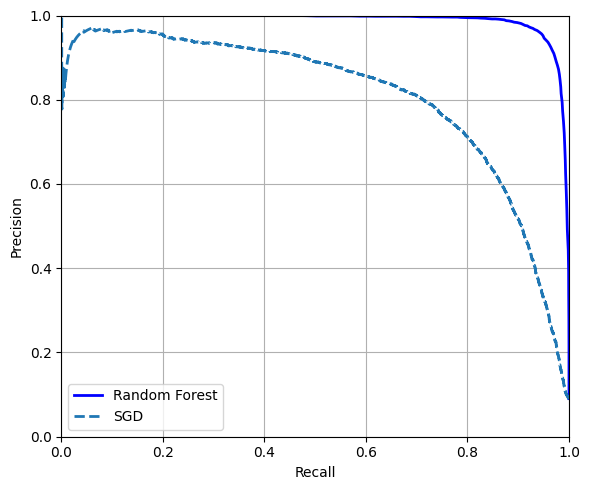

In [78]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

可以看到隨機森林分類器比SGD分類器表現好得多

若還是想看ROC Curve

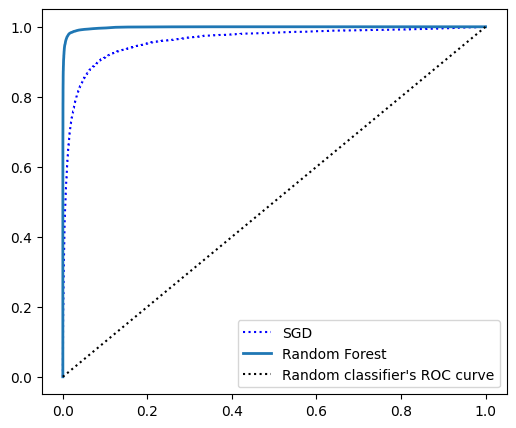

In [95]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.figure(figsize=(6, 5)) 
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, linewidth=2, label="Random Forest")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.legend(loc="lower right")

使用隨機森林分類器在訓練集預測:



(We could use cross_val_predict(forest_clf, X_train, y_train_5, cv=3) to compute y_train_pred_forest, but since we already have the estimated probabilities, we can just use the default threshold of 50% probability to get the same predictions much faster)

In [82]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
y_train_pred_forest

array([ True, False, False, ...,  True, False, False])

* F1

In [83]:
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

* AUC Score

In [80]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

* precision

In [ ]:
precision_score(y_train_5, y_train_pred_forest)

* recall

In [ ]:
recall_score(y_train_5, y_train_pred_forest)

## 補充

### calibration與predict_proba()解釋

模型計算出來的是估計的概率而並非實際的概率。 在上面隨機森林分類模型以 50% 到 60% 的概率分類為正面的圖像中，實際上大約有 94% 的正面圖像：

In [56]:
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

94.0%


因為大部分的應用中我們都希望知道模型的信心指數，所以大家會使用predict_proba()來做出具備機率性質的預測。我們要怎麼衡量我們的機率預測是否準確(不會偏離實際機率太遠)？ Calibration Curve能夠衡量你的機率是否準確！
詳細 : https://axk51013.medium.com/%E6%A8%A1%E5%9E%8B%E4%BF%A1%E5%BF%83%E7%9A%84%E6%9C%AC%E8%B3%AA-probability-calibration-cbc680a44efa

完整如何衡量任何一個predict_proba效果的code可以參考下面這份code，包含calibration curve、histogram跟brier score(要在test data上面測試就改成test data) 。

------------------------------------------------
SGD
accuracy = 0.9522666666666667
brier score = 0.3866335666705979
------------------------------------------------
RDF
accuracy = 1.0
brier score = 0.011726901666666666


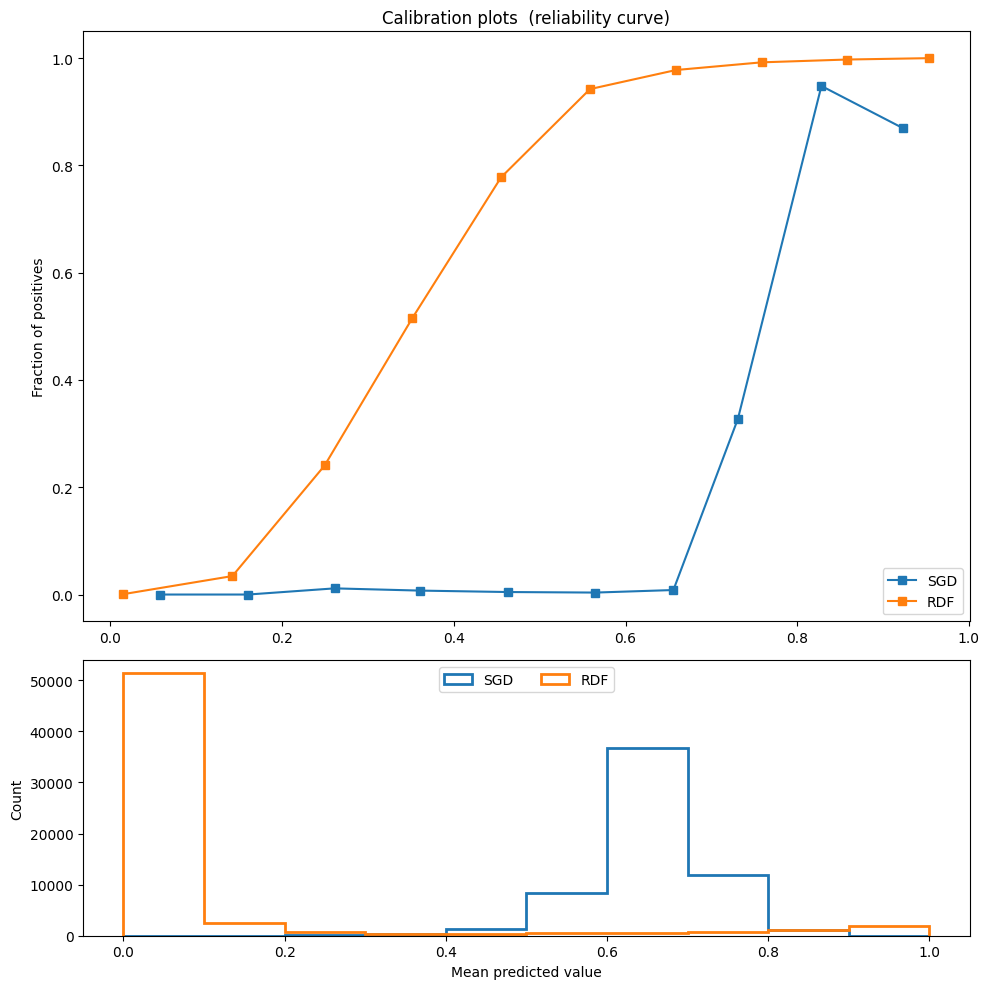

In [65]:
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

for clf, name in [(sgd_clf, 'SGD'),
                  (forest_clf, 'RDF')]:
    if hasattr(clf, "predict_proba"):
        prob_pos = cross_val_predict(clf, X_train, y_train_5, cv=3,method="predict_proba")[:, 1]
    else:  # use decision function
        prob_pos = cross_val_predict(clf, X_train, y_train_5, cv=3,method="decision_function")
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_train_5, prob_pos, n_bins=10)
    
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)
    
    print('------------------------------------------------')
    print(name)
    print('accuracy = ' + str(clf.score(X_train, y_train_5)))
    print('brier score = ' + str(brier_score_loss(y_train_5, prob_pos)))

    

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

第一張圖是Calibration curve，第二張圖是機率的分布

實際上ML裡calibration這個詞的意思，就是將預測校準成機率的形式，把不準的機率變準，把沒有機率性質的變成有機率性質。因為當我們有模型信心時我們多了不少資訊，我們可以從模型信心的下降來發現data drift，而不是真的到出錯了才發現這種問題。但是Calibration是現在ML的課程、書籍幾乎不會提到的細節，因為對performance沒有直接幫助。

In [68]:
calibrated_clf = CalibratedClassifierCV(base_estimator=forest_clf, cv=3)
calibrated_clf.fit(X_train, y_train_5)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(random_state=42),
                       cv=3)

In [71]:
len(calibrated_clf.calibrated_classifiers_)

3

In [76]:
calibrated_clf.predict_proba([some_digit])

array([[3.73957638e-05, 9.99962604e-01]])

## Multiclass Classification


Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are
capable of handling multiple classes directly. Others (such as Support Vector Machine
classifiers or Linear classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple
binary classifiers.

一些算法（例如支持向量機分類器）無法適應訓練集的大小，因此對於這些算法，OvO 是首選，因為在小訓練集上訓練許多分類器比在大訓練集上訓練幾個分類器更快。 然而，對於大多數二元分類算法，OvA 是首選。
 * one-versus-all or one-versus-the-rest (OvA or OvR):
  
  一對多 (OvA or OvR) 策略，以分類數字圖像為例(MNIST)，可以將數字圖像分為 10 類（從 0 到 9）的一種方法是訓練 10 個二元分類器，每個數字一個（0 檢測器、1 檢測器、2 檢測器，等等） 。 然後，當您想要對圖像進行分類時，可以從該圖像的每個分類器中獲得決策分數，然後選擇分類器輸出最高分數的類別。

* one-versus-one (OvO): 

另一種策略是為每一對數字訓練一個二元分類器一個區分 0 和 1，另一個區分 0 和 2，另一個區分 1 和 2，等等。 這稱為一對一 (OvO) 策略。 如果有 N 個類，則需要訓練 N × (N – 1) / 2 個分類器。 對於 MNIST 問題，這意味著要訓練 45 個二元分類器！ 當你想要對圖像進行分類時，你必須通過所有 45 個分類器運行圖像並查看哪個類別贏得最多的決鬥。 OvO 的主要優點是每個分類器只需要在訓練集中針對它必須區分的兩個類進行訓練。

Scikit-Learn 會檢測您何時嘗試將二元分類算法用於多類分類任務，並根據算法自動運行 OvA 或 OvO。

### 讓我們用 SVM 分類器試試

我們只訓練前2000張圖片，不然會跑很久

In [98]:
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5

SVC(random_state=42)

因為是SNM演算法，Scikit-Learn 使用 OvO 策略並訓練了 45 個二元分類器。

預測看看

In [99]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

預測沒錯！ 這段代碼實際上做了 45 次預測（每對類別一個），它選擇了贏得最多決鬥的類別。 如果調用 dicision_function()，您會看到它為每個observation返回 10 個分數：每個類一個。 根據分類器分數，每個類別的分數等於贏得決鬥的次數加上或減去打破平局的小調整（最大 +- 0.33）。

In [100]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

最高分是9.3，而且的確是屬於類別5

In [102]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [103]:
class_id = some_digit_scores.argmax()#分數中的最大值

svm_clf.classes_[class_id]

'5'

If you want decision_function() to return all 45 scores, you can set the decision_function_shape hyperparameter to "ovo". The default value is "ovr", but don't let this confuse you: SVC always uses OvO for training. This hyperparameter only affects whether or not the 45 scores get aggregated or not:

In [105]:
# extra code – shows how to get all 45 OvO scores if needed
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

但是，如果你想要強迫Scikit-Learn用OvO或OvR，可以用 OneVsOneClassifier 或 OneVsRestClassifier。

In [106]:
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [107]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [108]:
len(ovr_clf.estimators_)

10

### 讓我們用 Random Forest 分類器試試，結合簡單的參數隨機搜索看看

In [145]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import randint

In [143]:
pipeline = Pipeline([("random_forest", RandomForestClassifier(random_state=42))])

In [146]:
param_distribs = {'random_forest__max_features':randint(low=2,high=20)}

In [149]:
clf_random = RandomizedSearchCV(estimator = pipeline, param_distributions = param_distribs, 
                                scoring='neg_root_mean_squared_error', n_iter = 10, 
                                cv = 3, random_state=42)
clf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('random_forest',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001AF099763D0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

跑很久，先把模型存起來

In [154]:
joblib.dump(clf_random, "multiclass_clf_random_model.pkl")

['multiclass_clf_random_model.pkl']

預測看看

In [150]:
clf_random.predict([some_digit])

array(['5'], dtype=object)

隨機森林演算法會使用OvR，訓練十個二元分類器所以會有十個類別。

In [152]:
clf_random.predict_proba([some_digit]).round()

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

交叉驗證看看模型在不同驗證集的表現

In [151]:
cross_val_score(clf_random, X_train, y_train, cv=3, scoring="accuracy")

array([0.96345, 0.9612 , 0.9652 ])

## Error Analysis

假設現在參數、資料預處理什麼得都找完做完了，也試了幾個模型。在這裡，假設找到了一個有前途的模型clf_random，並且想找到改進它的方法。 一種方法是分析它所犯錯誤的類型。

首先，可以查看混淆矩陣。 使用 cross_val_predict() 函數進行預測，然後調用 confusion_matrix() 函數

In [172]:
y_train_pred = cross_val_predict(clf_random, X_train, y_train, cv=3)

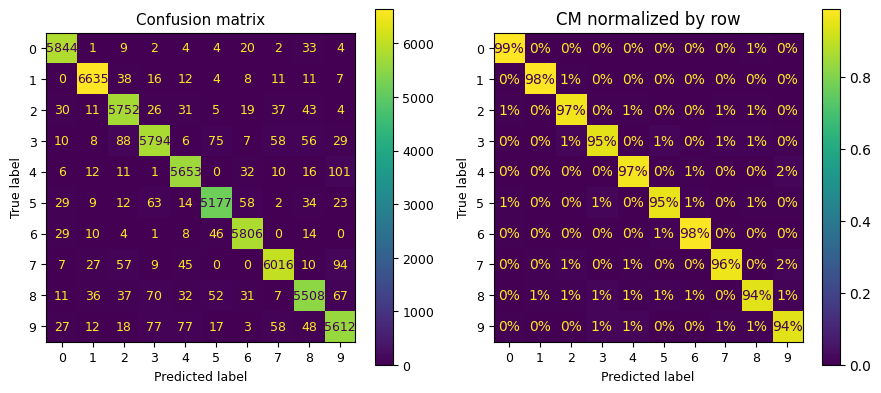

In [159]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc('font', size=10)#make the text smaller

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        normalize="true", values_format=".0%")
axs[1].set_title("CM normalized by row")
save_fig("confusion_matrix_plot_1")
plt.show()

左圖混淆矩陣看起來相當不錯，因為大多數圖像都在主對角線上，這意味著它們被正確分類了。 5 、8、9看起來比其他數字稍暗，這可能意味著數據中 5、8、9的圖像本來就較少，或者分類器在 5、8、9 上的表現不如其他數字。這就是為什麼通過將每個值除以相應（真實）類中的圖像總數（即除以行的總和）來標準化混淆矩陣很重要。 這可以簡單地通過設置 normalize='true' 來完成。 我們還可以指定 values_format='.0%' 參數來顯示沒有小數的百分比。

通過右圖，現在我們可以很容易地看到只有 94% 的 8 和 9 圖像被正確分類。 此外，所有 4 中有 2% 被歸類為 9，但只有 1% 的 9 被歸類為 4。

如果想讓錯誤更加突出，可以嘗試將零權重放在正確的預測上。根據下面左圖，現在可以更清楚地看到分類器所犯錯誤的種類。 第 9 類的欄現在變亮，這證實更多圖像被錯誤分類為 9。 但是注意如何解釋此圖中的百分比，我們已經排除了正確的預測。 例如，第 6 列、第 5 欄中的 41% 並不意味著 6s 的所有圖像中有 41% 被錯誤分類為 5s。 這意味著模型在 6 圖像上產生的錯誤中有 41% 被錯誤分類為 5。 實際上根據上面圖右，只有 1% 的 6 圖像被錯誤分類為 5。如果設置 normalize='pred'，也可以按列而不是按行對混淆矩陣進行歸一化。 例如根據下面右圖，您可以看到 37% 的錯誤分類 5 實際上是 3。

In [164]:
sample_weight = (y_train_pred != y_train)

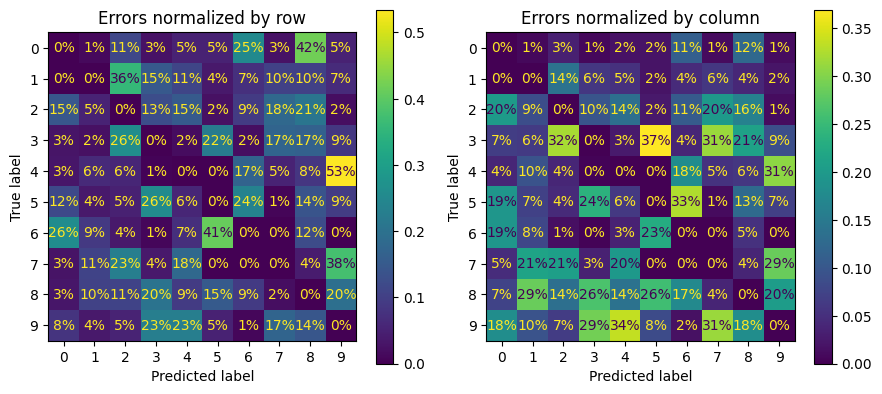

In [162]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0],
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
axs[1].set_title("Errors normalized by column")
save_fig("confusion_matrix_plot_2")
plt.show()
plt.rc('font', size=14)  # make fonts great again

分析混淆矩陣通常可以讓你深入了解如何改進分類器。 看這個圖，功夫應該花在減少假的9上了。 例如，可以嘗試為看起來像（但不是）9的數字收集更多訓練數據，以便分類器可以學習將它們與真正的9區分開來。 Or you could engineer new features that would help the classifier—for example, writing an algorithm to count the number of closed loops (e.g., 9 has two, 6 has one, 5 has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns stand out more, such as closed loops.

分析單個錯誤也是深入了解分類器正在做什麼以及失敗原因的好方法。 例如，讓我們繪製 3s 和 5s 的例子

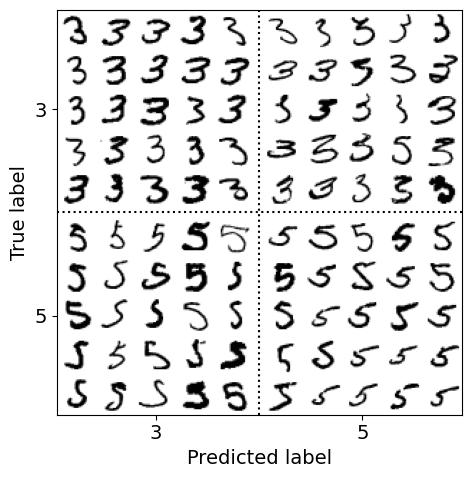

In [173]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
save_fig("error_analysis_digits_plot")
plt.show()

減少 3/5 混淆的一種方法是對圖像進行預處理，以確保它們居中且不會旋轉太多。 然而，這可能並不容易，因為它需要預測每個圖像的正確旋轉。 一種更簡單的方法包括使用訓練圖像的輕微移動和旋轉來增強訓練集。 這將迫使模型學會更容忍這種變化。 這稱為data augmentation。

## Multilabel Classication


到目前為止，每個obsevation總是只分配給一個類。 在某些情況下，您可能希望分類器為每個實例輸出多個類。 例如，考慮一個人臉識別分類器：如果它在同一張圖片上識別出幾個人，它應該怎麼做？ 當然，它應該為它識別的每個人附加一個標籤。 假設分類器經過訓練可以識別三張面孔，Alice、Bob 和 Charlie； 那麼當它顯示 Alice 和 Charlie 的照片時，它應該輸出 [1, 0, 1]（意思是“Alice yes，Bob no，Charlie yes”）。 這種輸出多個二進制標籤的分類系統稱為多標籤分類系統。

暫時不會進入人臉識別，但讓我們看一個更簡單的例子，只是為了說明目的：

創建一個 y_multilabel 數組，其中包含每個數字圖像的兩個目標標籤：第一個指示數字是否大（7、8 或 9），第二個指示它是否為奇數。 

In [178]:
y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

創建一個 KNeighborsClassifier （它支持多標籤分類，但並非所有分類器都支持），我們使用多目標數組對其進行訓練。

In [177]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

現在進行預測，並注意它輸出兩個標籤：

In [180]:
knn_clf.predict([some_digit])


array([[False,  True]])

它做對了！ 數字 5 確實不試large (False) 且試奇數 (True)。 評估多標籤分類器的方法有很多，選擇正確的指標實際上取決於您的項目。 例如，一種方法是測量每個單獨標籤的 F1 分數（或前面討論的任何其他二元分類器指標），然後簡單地計算平均分數。 

計算交叉驗證後F1的平均所得分：

In [181]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

上面假設所有標籤都同等重要，但事實可能並非如此。 特別是，如果您擁有的Alice照片比Bob或Charlie的照片多得多，您可能希望對分類器在愛麗絲照片上的得分賦予更多權重。 一個簡單的選擇是為每個標籤賦予與其同等數目的權重（即具有該目標標籤的observation數）。 為此，只需設置 average="weighted"

In [182]:
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

如果希望使用本身不支持多標籤分類的分類器，例如 SVC，一種可能的策略是為每個標籤訓練一個模型。 然而，這種策略可能很難捕獲標籤之間的依賴關係。 例如，一個大數字（7,8 或 9）是奇數的可能性是偶數的兩倍，但是“奇數”標籤的分類器不知道“大”標籤的分類器預測的是什麼(即他們兩個應該有交互關係，但現在卻變成獨立的)。 為了解決這個問題，可以將模型組織成一個鏈：當一個模型進行預測時，它使用輸入特徵加上鍊中在它之前的模型的所有預測。

可以使用Sickit-Learn的ChainClassifier做到這點

In [184]:
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [185]:
chain_clf.predict([some_digit])

array([[0., 1.]])

## Multioutput Classication

It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

就是多元分類，其中各類別又可以有多個值的意思

為了說明這一點，讓我們構建一個從圖像中去除噪聲的系統。 它將以noisy的數字圖像作為輸入，並且（希望）輸出乾淨的數字圖像array(以像素array的形式，就像 MNIST 圖像一樣。) 請注意，分類器的輸出是多標籤（每個小像素一個標籤），每個標籤可以有多個值（像素強度範圍從 0 到 255）。 因此，它是multioutput classification的一個例子。

分類和回歸之間的界限有時是模糊的，例如在這個例子中。 可以說，預測像素強度更類似於回歸而不是分類。 此外，多輸出系統不僅限於分類任務； 甚至可以擁有一個為每個observation輸出多個標籤的系統，包括class labels 和value labels。

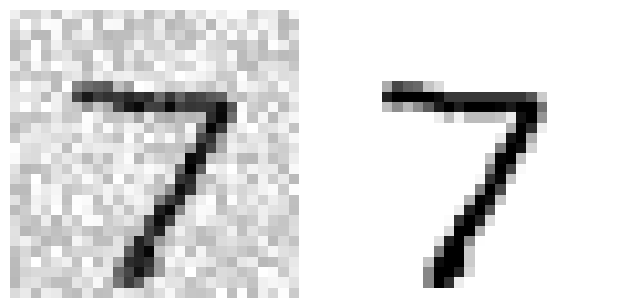

In [189]:
np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))#隨機整數值介於 0 和 100 之間。the array will have a number of rows equal to the length of the "X_train" array, and each row will have 784 elements.
X_train_mod = X_train + noise#將隨機創建的噪音加到訓練集
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise#將隨機創建的噪音加到測試集
y_train_mod = X_train#訓練集的y原本是0~0中其中一個數字，現在將訓練集的x(即256個欄位)當成新的y
y_test_mod = X_test#測試集的y原本是0~0中其中一個數字，現在將測試集的x(即256個欄位)當成新的y


plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
save_fig("noisy_digit_example_plot")
plt.show()


左邊是有噪聲的輸入圖像，右邊是乾淨的target圖像(為了範例窺探測試數據)。 現在讓我們訓練分類器並讓它清理這張圖片：

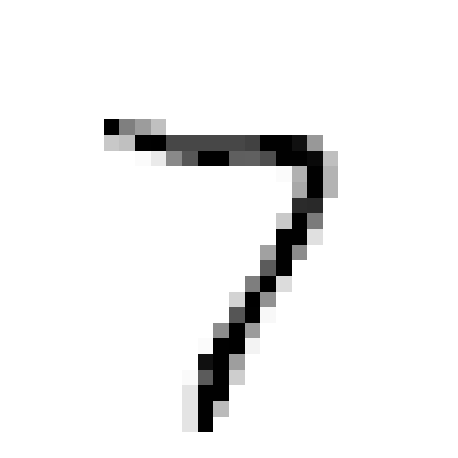

In [190]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")  # extra code – saves Figure 3–13
plt.show()